# Teste dos modelos de classificação 

### Criação do modelo

In [1]:
from model import create_model

Using TensorFlow backend.


In [2]:
nn4_small2 = create_model()

Instructions for updating:
Colocations handled automatically by placer.


### Importando os pesos

In [3]:
nn4_small2.load_weights('weights/nn4.small2.v1.h5')

### Criação do armazenamento

In [4]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('dataset')

### Alinhamento

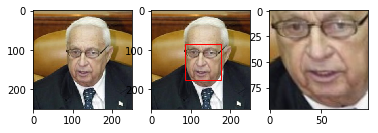

In [5]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image(metadata[2].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

In [6]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

### Extração dos _embedding vectors_

In [7]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    # escala os valores RGB para o intervalo [0,1]
    img = (img / 255.).astype(np.float32)
    # obtém um embedding vector por imagem
    embedded[i] = nn4_small2.predict(np.expand_dims(img, axis=0))[0]

### Definição de distância

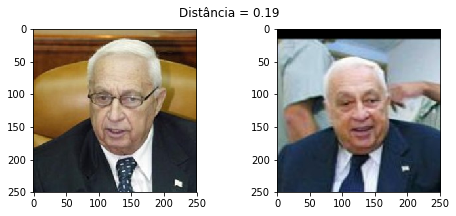

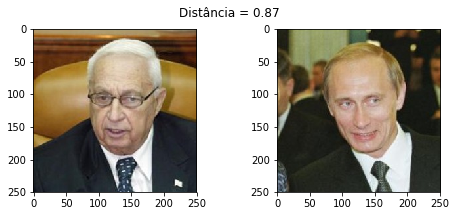

In [8]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle('Distância = ' + "{:.2f}".format(distance(embedded[idx1], embedded[idx2])))
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 12)

### Teste

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

# O conjunto teste não pode conter nenhum elemento desconhecido
train_idx = np.arange(metadata.shape[0]) % 2 != 0
for index, m in enumerate(metadata):
    if m.name == "desconhecido":
        train_idx[index] = False

test_idx = ~train_idx        
        
X_train = embedded[train_idx]

X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_knn = knn.predict(X_test)
y_svc = svc.predict(X_test)

for n, (x, y_knn_el) in enumerate(zip(X_test, y_knn)):
    identity = encoder.inverse_transform([y_knn_el])[0]
    class_weights = [embedded[i] for i in np.arange(metadata.shape[0])[train_idx] if metadata[i].name == identity]
    d = np.amin([distance(x,w) for w in class_weights])
    if(d > 0.57):
        y_knn[n] = encoder.transform(["desconhecido"])[0]
        
for n, (x, y_knn_el) in enumerate(zip(X_test, y_svc)):
    identity = encoder.inverse_transform([y_knn_el])[0]
    class_weights = [embedded[i] for i in np.arange(metadata.shape[0])[train_idx] if metadata[i].name == identity]
    d = np.amin([distance(x,w) for w in class_weights])
    if(d > 0.57):
        y_svc[n] = encoder.transform(["desconhecido"])[0]

class_knn = classification_report(y_test, y_knn, target_names=encoder.classes_)
class_svc = classification_report(y_test, y_svc, target_names=encoder.classes_)

print(class_knn)
print(class_svc)



                       precision    recall  f1-score   support

         Ariel_Sharon       1.00      1.00      1.00         5
Arnold_Schwarzenegger       1.00      0.80      0.89         5
         Colin_Powell       0.83      1.00      0.91         5
      Donald_Rumsfeld       1.00      0.60      0.75         5
        George_W_Bush       0.83      1.00      0.91         5
    Gerhard_Schroeder       0.71      1.00      0.83         5
          Hugo_Chavez       1.00      1.00      1.00         5
       Jacques_Chirac       1.00      1.00      1.00         5
           Tony_Blair       0.80      0.80      0.80         5
       Vladimir_Putin       1.00      1.00      1.00         5
         desconhecido       0.89      0.80      0.84        10

            micro avg       0.90      0.90      0.90        60
            macro avg       0.92      0.91      0.90        60
         weighted avg       0.91      0.90      0.90        60

                       precision    recall  f1-score

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

prec_med_knn = precision_score(y_test, y_knn, average='macro')
rec_med_knn = recall_score(y_test, y_knn, average='macro')
prec_med_svc = precision_score(y_test, y_svc, average='macro')
rec_med_svc = recall_score(y_test, y_svc, average='macro')
macro_f1_knn = f1_score(y_test, y_svc, average='macro')
micro_f1_knn = f1_score(y_test, y_svc, average='micro')
macro_f1_svc = f1_score(y_test, y_svc, average='macro')
micro_f1_svc = f1_score(y_test, y_svc, average='micro')

print("Precisão média KNN = {:.2f}".format(prec_med_knn))
print("Revocação média KNN = {:.2f}".format(rec_med_knn))
print("Precisão média SVM = {:.2f}".format(prec_med_svc))
print("Revocação média SVM = {:.2f}".format(rec_med_svc))
print("Macro-F1 SVM = {:.2f}".format(macro_f1_svc))
print("Micro-F1 SVM = {:.2f}".format(micro_f1_svc))
print("Macro-F1 KNN = {:.2f}".format(macro_f1_knn))
print("Micro-F1 KNN = {:.2f}".format(micro_f1_knn))

Precisão média KNN = 0.92
Revocação média KNN = 0.91
Precisão média SVM = 0.91
Revocação média SVM = 0.91
Macro-F1 SVM = 0.91
Micro-F1 SVM = 0.90
Macro-F1 KNN = 0.91
Micro-F1 KNN = 0.90
